<a href="https://colab.research.google.com/github/Bo-kyoung/AI-practices/blob/main/VGG16_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

transform = transforms.Compose(
    [transforms.ToTensor()])
     #,transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])


In [3]:
learning_rate = 0.01
training_epochs = 74
batch_size = 256

In [4]:
CIFAR10_train = dsets.CIFAR10(root='data/',train = True, download=True, transform=transform)
CIFAR10_test = dsets.CIFAR10(root='data/', train=False, download = True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
data_loader = DataLoader(dataset = CIFAR10_train, batch_size = batch_size, shuffle = True,drop_last = True)
test_loader = DataLoader(dataset = CIFAR10_test, batch_size = batch_size, shuffle = False,drop_last = True)


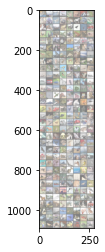

  cat   ship   ship  plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
%matplotlib inline
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

dataiter = iter(test_loader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

print('  '.join('%5s' % classes[labels[j]] for j in range(4)))


In [8]:
class VGG16(nn.Module):
  def __init__(self, init_weights = True):
    super(VGG16, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = 3,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,out_channels = 64,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels = 64,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =128,out_channels = 128,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 128,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =256,out_channels = 256,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(in_channels =256,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels =512,out_channels = 512,kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        )
    if init_weights: 
      self._initialize_weights()
    
    self.classfier = nn.Sequential(
    nn.Linear(4*4*512,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,4096),
    nn.ReLU(True),
    nn.Dropout(0.5), 
    nn.Linear(4096,10)
    )
  
  


  def forward(self, x):
    out = self.conv(x)
    out = out.view(out.size(0),-1)
    out = self.classfier(out)
    return out
#https://blog.naver.com/PostView.naver?blogId=mmmy2513&logNo=222300615187
#https://blogofth-lee.tistory.com/265?category=872318
  def _initialize_weights(self): 
    for m in self.modules(): 
      if isinstance(m, nn.Conv2d): 
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
        if m.bias is not None: 
          nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.BatchNorm2d): 
        nn.init.constant_(m.weight, 1) 
        nn.init.constant_(m.bias, 0) 
      elif isinstance(m, nn.Linear): 
        nn.init.normal_(m.weight,0,0.01) 
        nn.init.constant_(m.bias, 0)




In [9]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(),lr = learning_rate,momentum = 0.9)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma =0.9)

In [11]:
total_batch = len(data_loader)
print(total_batch)

195


In [42]:
loss_graph = []
training_epochs = 100
for epoch in range(training_epochs):
    avg_cost = 0
    running_loss = 0.0

    for i , data in enumerate(data_loader, 0):
      X, Y = data
      X = X.to(device)
      Y = Y.to(device)
     
      hypothesis = model(X)
      cost = criterion(hypothesis, Y)
      optimizer.zero_grad()
      cost.backward()
      optimizer.step()


      avg_cost += cost / total_batch
    
    loss_graph.append(avg_cost)

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))



[Epoch:    1] cost = 0.193687737
[Epoch:    2] cost = 0.164028466
[Epoch:    3] cost = 0.132466406
[Epoch:    4] cost = 0.107872956
[Epoch:    5] cost = 0.0984914154
[Epoch:    6] cost = 0.0863891467
[Epoch:    7] cost = 0.079735823
[Epoch:    8] cost = 0.0629248545
[Epoch:    9] cost = 0.0625277981
[Epoch:   10] cost = 0.0601282716
[Epoch:   11] cost = 0.0498377942
[Epoch:   12] cost = 0.0430263653
[Epoch:   13] cost = 0.042209588
[Epoch:   14] cost = 0.0342185795


KeyboardInterrupt: ignored

In [43]:
loss_graph_2 = torch.as_tensor(loss_graph,device='cpu')

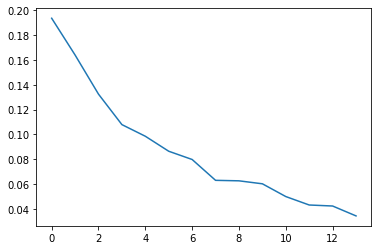

In [44]:
plt.plot(loss_graph_2)

In [45]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data,1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('acc: %d %%' % (100*correct/total))

acc: 78 %
